# Simulación de Montecarlo para Estimar Precios Futuros de Acciones

Bienvenidos a este capítulo que se centra en el uso de las simulaciones de Montecarlo para estimar los precios futuros de una acción. Durante este notebook, exploraremos una técnica poderosa y versátil que se utiliza comúnmente en el mundo de las finanzas para evaluar el riesgo, valorar derivados y el rendimiento de inversiones: la simulación de Montecarlo.

**TEMAS A TRATAR**

En este notebook, abordaremos los siguientes temas clave:

1. **Simulaciones de Montecarlo**

Las simulaciones de Montecarlo son una técnica estadística que se utiliza para modelar el comportamiento de sistemas complejos o inciertos mediante la generación de múltiples escenarios aleatorios. En el contexto financiero, podemos aplicar esta técnica para simular los retornos futuros de una acción, lo que nos permitirá estimar su precio futuro.

2. **Retornos Logarítmicos y Distribución Normal**

Una de las premisas fundamentales de las simulaciones de Montecarlo en finanzas es que los retornos logarítmicos de una acción siguen una distribución normal. Esto significa que, en promedio, los retornos futuros tienden a seguir una tendencia central, y la mayoría de las observaciones se agrupan alrededor de esa media. Esto nos proporciona un punto de partida para nuestras simulaciones.

3. **Independencia de Retornos**

Otra suposición clave es que los retornos logarítmicos son independientes entre sí. Esto significa que el rendimiento de un período no está relacionado con el rendimiento de otros períodos. Aunque esta suposición puede no ser completamente precisa en la realidad, es un enfoque simplificado que se utiliza ampliamente en simulaciones de Montecarlo.

4. **Simulación de Retornos Futuros**

Utilizaremos la característica de independencia y la distribución normal de los retornos logarítmicos para simular retornos futuros. Generaremos números aleatorios que sigan una distribución normal con la media y desviación típica de los retornos pasados. Estos números representarán los retornos en diferentes períodos futuros.

5. **Cálculo de Precios Futuros**

Para estimar los precios futuros de la acción, utilizaremos los retornos simulados. Sumaremos los retornos al precio actual y calcularemos la exponencial para obtener los precios futuros. Esto nos proporcionará un rango de posibles trayectorias de precios.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
import mplfinance as mpf
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

plt.style.use('ggplot')

Nos bajamos los precios de cierre ajustados del índice SP500 de Yahoo Finance. 

In [18]:
sp500_df = yf.download(tickers='^GSPC')[['Adj Close']]

[*********************100%%**********************]  1 of 1 completed


Vamos a simular posibles series a futuro del índice SP500. Elegimos el periodo entre los años 2010 y 2018

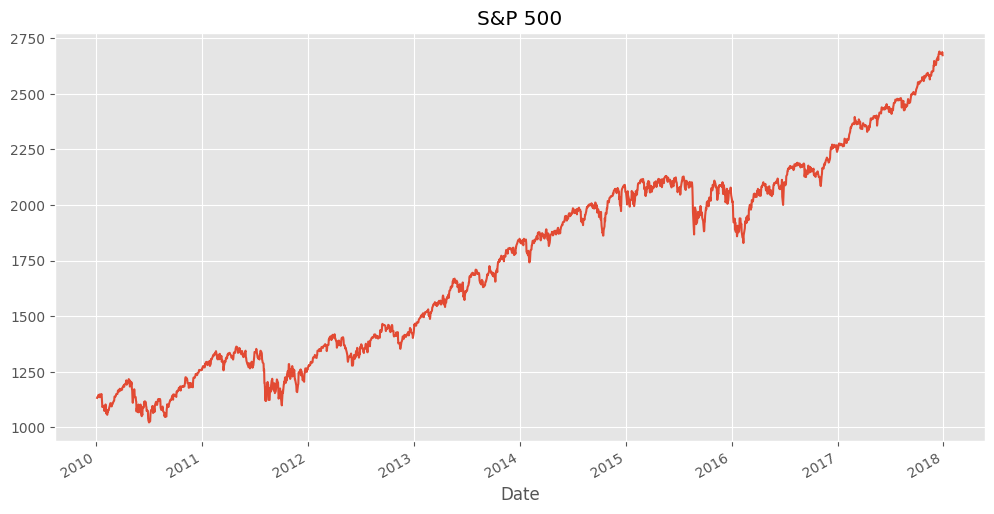

In [19]:

start_date = '2010-01-01'
end_date = '2017-12-31'

sp500_per = sp500_df[start_date:end_date]
sp500_per.plot(figsize=(12,6), legend=False, title='S&P 500');

CALCULAMOS LOS RETORNOS LOGARÍTMICOS, LA MEDIA Y LA DESVIACIÓN TÍPICA Y COMPROBAMOS SI SE AJUSTAN A UNA DISTRIBUCIÓN NORMAL Y SI SON INDEPENDIENTES

In [20]:
ret_sp500_per = np.log(sp500_per).diff().dropna()

#Calculamos la media y la desviación estándar de los rendimientos
sp500_media = ret_sp500_per.mean()
sp500_std = ret_sp500_per.std()

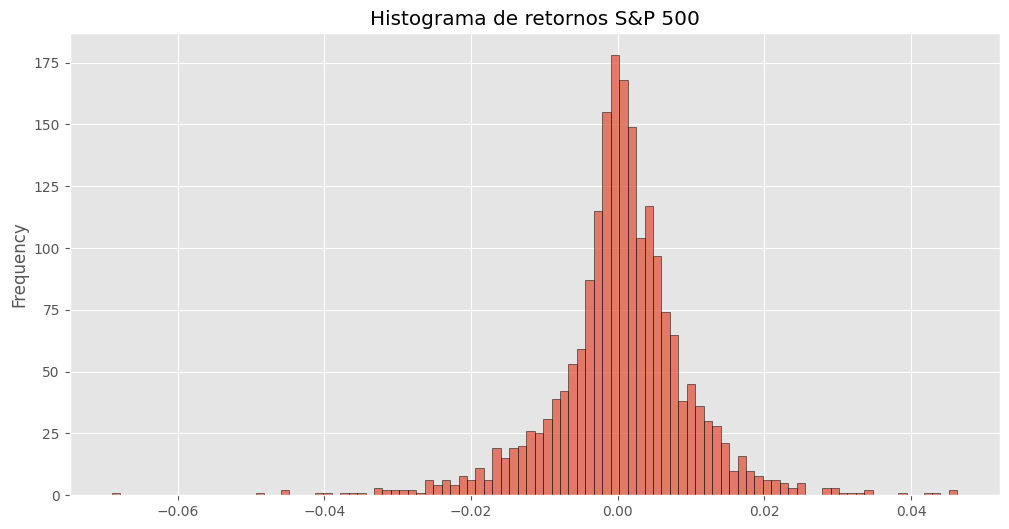

In [21]:
#Vemos si los rendimientos siguen una distribución normal
ret_sp500_per.plot(kind='hist', bins=100, figsize=(12,6), title='Histograma de retornos S&P 500', edgecolor='black', legend=False, alpha=0.7);

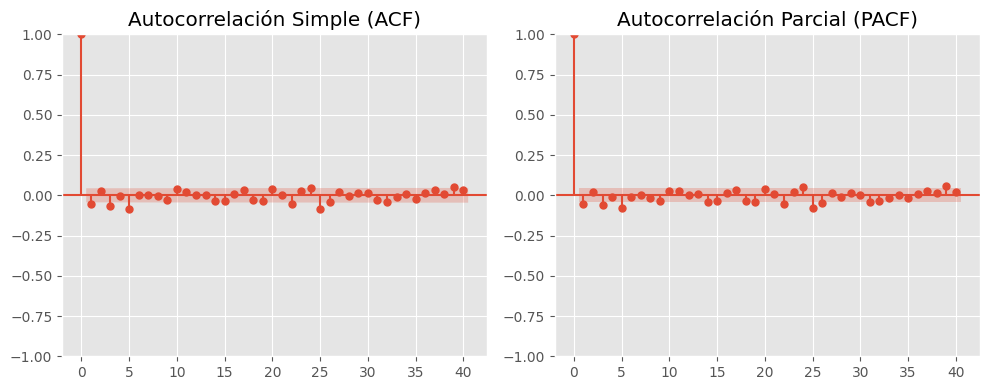

In [22]:
# Crear una figura con dos subplots (1 fila y 2 columnas)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Graficar ACF (Autocorrelación Simple)
sm.graphics.tsa.plot_acf(ret_sp500_per, lags=40, ax=ax[0])
ax[0].set_title('Autocorrelación Simple (ACF)')

# Graficar PACF (Autocorrelación Parcial)
sm.graphics.tsa.plot_pacf(ret_sp500_per, lags=40, ax=ax[1])
ax[1].set_title('Autocorrelación Parcial (PACF)')

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

GENERAMOS LOS RETORNOS FUTUROS USANDO LA MEDIA Y LA DESVIACIÓN TÍPICA DE LOS RETORNOS PASADOS Y UNA DISTRIBUCIÓN NORMAL

In [23]:
#Vamos a simular el mismo número de días que tenemos en el histórico
n_days = ret_sp500_per.shape[0]

#Vamos a simular 100 escenarios de rendimientos
n_sim = 100

#Generamos los rendimientos simulados
ret_sim = np.random.normal(sp500_media, sp500_std, (n_days, n_sim))

#Calculamos los precios simulados
ret_cum_sim = ret_sim.cumsum(axis=0)
sp500_sim = sp500_per.values[0][0] * np.exp(ret_cum_sim)


Añadimos una fila inicial con el mismo valor que la primera fila de la serie de precios para poder calcular los precios futuros

In [24]:
#Generamos la fila inicial con el precio inicial
fila_0 = np.ones((1, n_sim))*sp500_per.values[0][0]

#Concatenamos la fila inicial con los precios simulados
precios_sim = np.concatenate((fila_0, sp500_sim), axis=0)

#Convertimos los precios simulados en un DataFrame de Pandas
precios_sim_df = pd.DataFrame(precios_sim, index=sp500_per.index, columns=range(n_sim))

HACEMOS UNA GRÁFICA CON LOS PRECIOS SIMULADOS Y LOS PRECIOS REALES

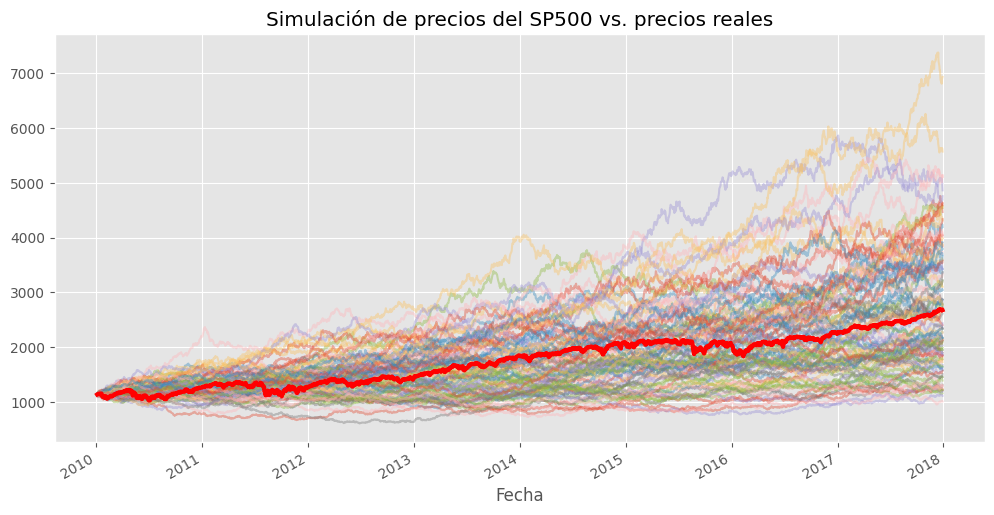

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
precios_sim_df.plot(legend=False, alpha=0.4, ax=ax) #Graficamos los precios simulados
sp500_per.plot(ax=ax, color='red', linewidth=3, legend=False) #Graficamos los precios reales
plt.title('Simulación de precios del SP500 vs. precios reales')
plt.xlabel('Fecha')
plt.show()

EN VEZ DE GRAFICAR TODAS LAS SERIES, GRAFICAMOS LA MEDIA, MEDIANA Y LOS PERCENTILES 5 Y 95 DE LAS SERIES SIMULADAS

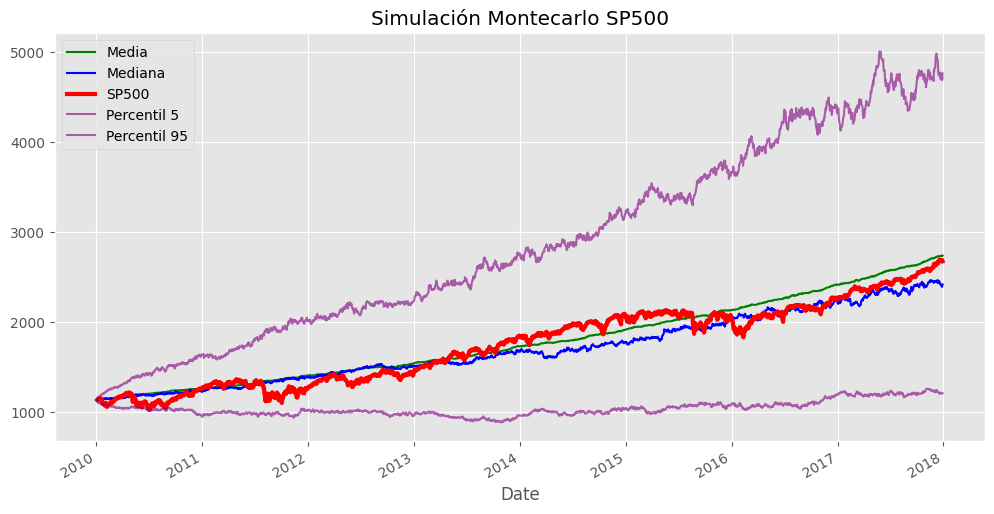

In [26]:
#Calculamos los percentiles 5 y 95 de los precios simulados
precios_quantile_evol = precios_sim_df.quantile(q=[0.05,0.95],axis=1).T

#Hacemos la gráfica
fig, ax = plt.subplots(figsize=(12,6))
precios_sim_df.mean(axis=1).plot(ax=ax, color='green');
precios_sim_df.median(axis=1).plot(ax=ax, color='blue');
sp500_per.plot(ax=ax, color='red', linewidth=3)
precios_quantile_evol.plot(ax=ax, color='purple',  alpha=0.6)
plt.legend(['Media', 'Mediana', 'SP500', 'Percentil 5', 'Percentil 95'])
plt.title('Simulación Montecarlo SP500')
plt.show()

HEMOS UTILIZADO LOS DATOS HISTÓRICOS PARA SIMULAR ESOS MISMOS DATOS HISTÓRICOS. ¿QUÉ PASARÍA SI UTILIZAMOS LOS DATOS HISTÓRICOS PARA SIMULAR DATOS FUTUROS?

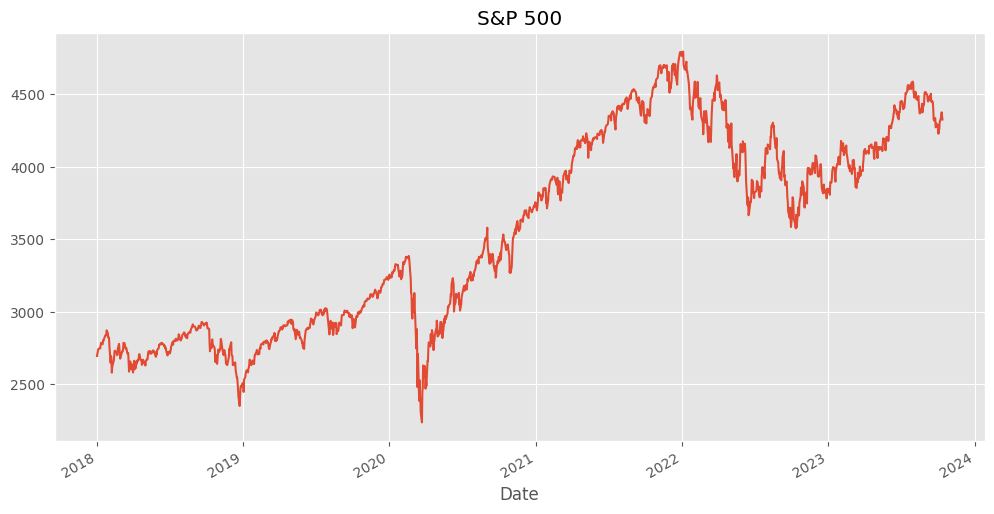

In [27]:
#Nos quedasmos con los precios reales a partir del 31 de diciembre de 2017
sp500_resto = sp500_df['2017-12-31':]
#Calculamos los rendimientos
ret_sp500_resto = np.log(sp500_resto).diff().dropna()
#Hacemos una gráfica de los precios futuros
sp500_resto.plot(figsize=(12,6), legend=False, title='S&P 500');

Mirad la diferencia entre los precios que usamos para generar los retornos y los precios futuros que vamos a simular

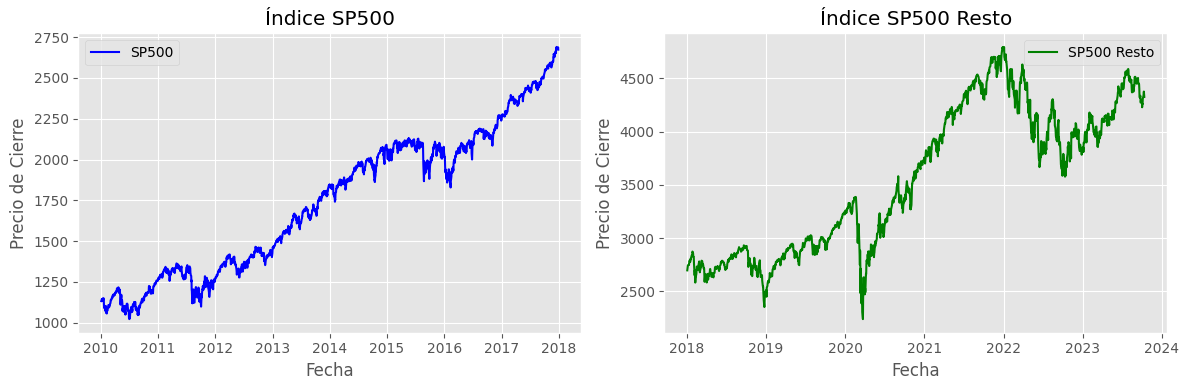

In [29]:
# Crear una figura con dos subplots (1 fila y 2 columnas)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Graficar los datos de sp500 en el primer subplot
ax[0].plot(sp500_per.index, sp500_per, label='SP500', color='blue')
ax[0].set_title('Índice SP500')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('Precio de Cierre')
ax[0].legend()

# Graficar los datos de sp500_resto en el segundo subplot
ax[1].plot(sp500_resto.index, sp500_resto, label='SP500 Resto', color='green')
ax[1].set_title('Índice SP500 Resto')
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('Precio de Cierre')
ax[1].legend()

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

In [30]:
#simulamos los mismos días que tenemos en el futuro
n_days = ret_sp500_resto.shape[0]
#simulamos 100 escenarios de rendimientos
n_sim = 100
#Generamos los rendimientos simulados
ret_sim = np.random.normal(sp500_media, sp500_std, (n_days, n_sim))
#Calculamos los precios simulados
ret_cum_sim = ret_sim.cumsum(axis=0)
sp500_sim = sp500_resto.values[0][0] * np.exp(ret_cum_sim)

In [31]:
#Generamos la fila inicial con el precio inicial
fila_0 = np.ones((1, n_sim))*sp500_resto.values[0][0]
#Concatenamos la fila inicial con los precios simulados
precios_sim = np.concatenate((fila_0, sp500_sim), axis=0)
#Convertimos los precios simulados en un DataFrame de Pandas
precios_sim_df = pd.DataFrame(precios_sim, index=sp500_resto.index, columns=range(n_sim))

HACEMOS UNA GRÁFICA CON LOS PRECIOS SIMULADOS Y LOS PRECIOS REALES

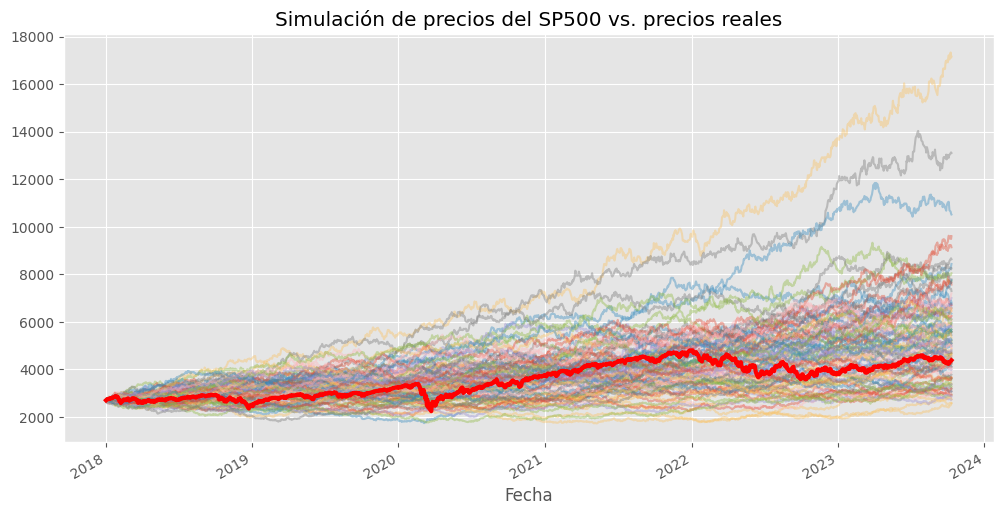

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
precios_sim_df.plot(legend=False, alpha=0.4, ax=ax)
sp500_resto.plot(ax=ax, color='red', linewidth=3, legend=False)
plt.title('Simulación de precios del SP500 vs. precios reales')
plt.xlabel('Fecha')
plt.show()

EN VEZ DE GRAFICAR TODAS LAS SERIES, GRAFICAMOS LA MEDIA, MEDIANA Y LOS PERCENTILES 5 Y 95 DE LAS SERIES SIMULADAS

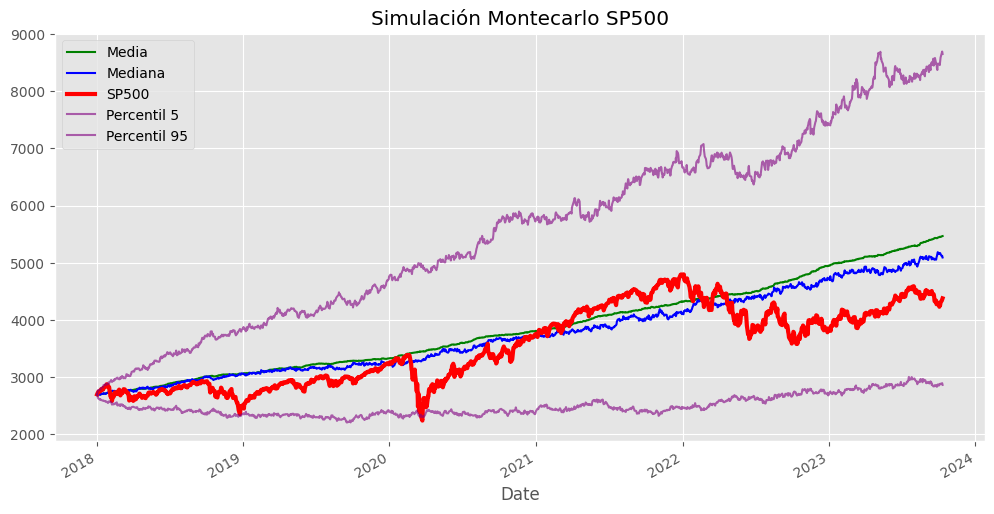

In [52]:
fig, ax = plt.subplots(figsize=(12,6))
precios_sim_df.mean(axis=1).plot(ax=ax, color='green');
precios_sim_df.median(axis=1).plot(ax=ax, color='blue');
sp500_resto.plot(ax=ax, color='red', linewidth=3)
precios_quantile_evol = precios_sim_df.quantile(q=[0.05,0.95],axis=1).T
precios_quantile_evol.plot(ax=ax, color='purple',  alpha=0.6)
plt.legend(['Media', 'Mediana', 'SP500', 'Percentil 5', 'Percentil 95'])
plt.title('Simulación Montecarlo SP500')
plt.show()